In [1]:
#DS imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydataset
import seaborn as sns
from scipy import stats


#Modeling and scaling
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split

#My files
import env
import wrangle as w
import model as m

np.random.seed(123)

## Exercises: Getting Data

In [2]:
#get zillow data
df =w.get_zillow_data()

In [3]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [4]:
#Clean Zillow data
df = w.clean_zillow(df)

In [5]:
# Find the total number of Null values in each column of our DataFrame.
df.isnull().sum()

bedrooms      0
bathrooms     0
area          0
tax_value     0
year_built    0
tax_amount    0
fips          0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152863
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bedrooms    float64
 1   bathrooms   float64
 2   area        float64
 3   tax_value   float64
 4   year_built  float64
 5   tax_amount  float64
 6   fips        float64
dtypes: float64(7)
memory usage: 130.6 MB


In [7]:
df.head()

,bedrooms,bathrooms,area,tax_value,year_built,tax_amount,fips
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
11,0.0,0.0,1200.0,5328.0,1972.0,91.60,6037.0
14,0.0,0.0,171.0,6920.0,1973.0,255.17,6037.0


### 1. Apply the scalers we talked about in this lesson to your data and visualize the results for the unscaled and scaled distribution 

In [8]:
train, validate, test = w.train_validate_test_split(df)

In [9]:
train.head()

,bedrooms,bathrooms,area,tax_value,year_built,tax_amount,fips
1898732,1.0,2.0,1177.0,832504.0,1944.0,10032.98,6037.0
1404981,4.0,2.0,1596.0,196039.0,1947.0,3198.84,6037.0
443327,4.0,2.0,1325.0,454598.0,1954.0,5636.68,6037.0
430566,4.0,3.0,2725.0,893473.0,1994.0,9505.90,6059.0
1936253,2.0,1.0,912.0,769598.0,1937.0,8731.20,6059.0


In [11]:
# Validate my split

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (1498110, 7)
validate -> (321089, 7)
test -> (321036, 7)


In [12]:
train.head()

,bedrooms,bathrooms,area,tax_value,year_built,tax_amount,fips
1898732,1.0,2.0,1177.0,832504.0,1944.0,10032.98,6037.0
1404981,4.0,2.0,1596.0,196039.0,1947.0,3198.84,6037.0
443327,4.0,2.0,1325.0,454598.0,1954.0,5636.68,6037.0
430566,4.0,3.0,2725.0,893473.0,1994.0,9505.90,6059.0
1936253,2.0,1.0,912.0,769598.0,1937.0,8731.20,6059.0


In [13]:
#Prepare for scaling by limiting to three features and target
columns_to_scale = ['bedrooms', 'bathrooms','area','tax_value']

In [14]:
#making copies for each method
train_scaled_minmax = train.copy()
train_scaled_standard = train.copy()
train_scaled_robust = train.copy()

### Looking at this dataset, we want to scale several columns: bedrooms, bathrooms, tax_value

### Min-Max Scaler

In [15]:
#Using min max scaler
scaler = MinMaxScaler()
train_scaled_minmax[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])

In [16]:
train_scaled_minmax

,bedrooms,bathrooms,area,tax_value,year_built,tax_amount,fips
1898732,0.04,0.06250,0.001235,0.009458,1944.0,10032.98,6037.0
1404981,0.16,0.06250,0.001674,0.002227,1947.0,3198.84,6037.0
443327,0.16,0.06250,0.001390,0.005164,1954.0,5636.68,6037.0
430566,0.16,0.09375,0.002860,0.010150,1994.0,9505.90,6059.0
1936253,0.08,0.03125,0.000956,0.008743,1937.0,8731.20,6059.0
...,...,...,...,...,...,...,...
833807,0.08,0.03125,0.000872,0.001813,1949.0,2456.30,6037.0
1132992,0.12,0.09375,0.001894,0.002250,1981.0,3156.68,6037.0
1867748,0.16,0.12500,0.002797,0.005320,1972.0,5386.39,6037.0
286531,0.08,0.03125,0.001118,0.000495,1932.0,743.37,6037.0


Text(0.5, 1.0, 'Scaled')

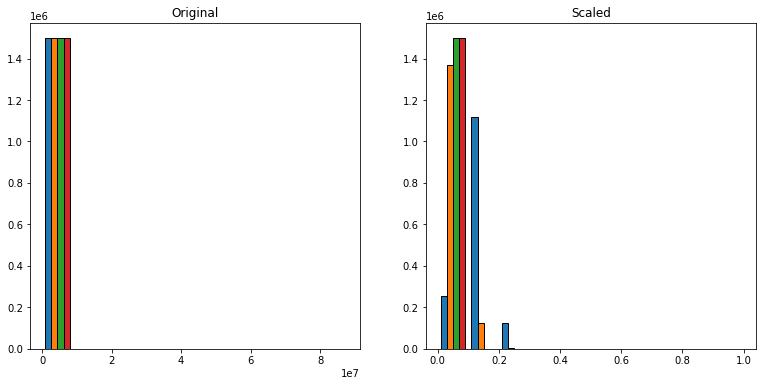

In [17]:
#Visualize
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(train[columns_to_scale], ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(train_scaled_minmax[columns_to_scale], ec='black')
plt.title('Scaled')

In [19]:
print(train.bedrooms.head(2))
print(train_scaled_minmax.bedrooms.head(2))

1898732    1.0
1404981    4.0
Name: bedrooms, dtype: float64
1898732    0.04
1404981    0.16
Name: bedrooms, dtype: float64


### Standard Scaler

In [20]:
#Standard Scaler
scaler = StandardScaler()
# Fit and transform on training data
train_scaled_standard[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])

Text(0.5, 1.0, 'Scaled')

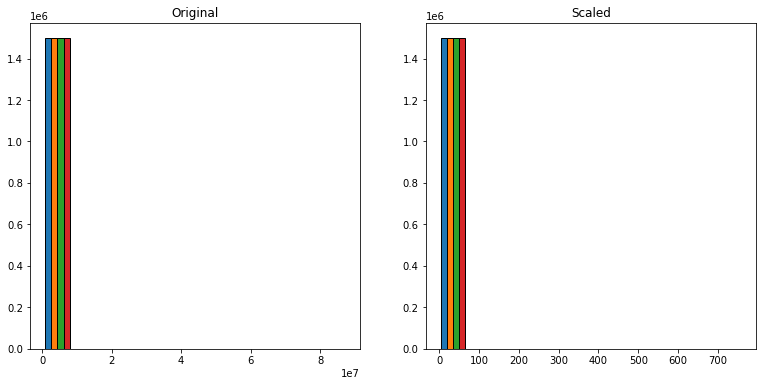

In [21]:
#Visualize
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(train[columns_to_scale], ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(train_scaled_standard[columns_to_scale], ec='black')
plt.title('Scaled')

In [22]:
print(train.bedrooms.head(2))
print(train_scaled_standard.bedrooms.head(2))

1898732    1.0
1404981    4.0
Name: bedrooms, dtype: float64
1898732   -2.467781
1404981    0.749688
Name: bedrooms, dtype: float64


### Robust Scaler

In [23]:
#Robust Scaler
scaler = RobustScaler()
# Fit and transform on training data
train_scaled_robust[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])

Text(0.5, 1.0, 'Scaled')

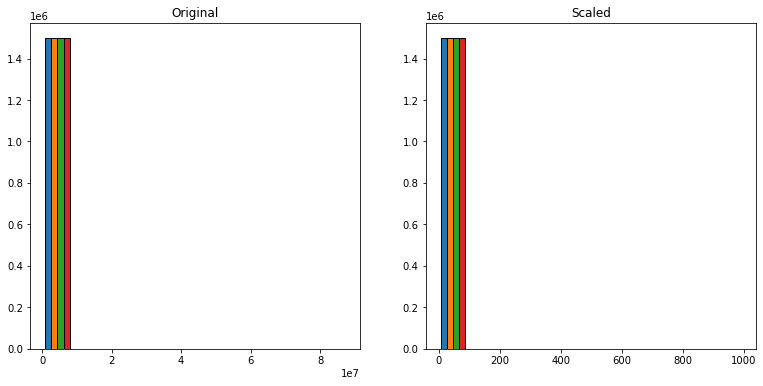

In [24]:
#Visualize this
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(train[columns_to_scale], ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(train_scaled_robust[columns_to_scale], ec='black')
plt.title('Scaled')

In [26]:
print(train.bedrooms.head(2))
print(train_scaled_robust.bedrooms.head(2))

1898732    1.0
1404981    4.0
Name: bedrooms, dtype: float64
1898732   -2.0
1404981    1.0
Name: bedrooms, dtype: float64


### 2. Apply the .inverse_transform method to your scaled data. Is the resulting dataset the exact same as the original data?

### Yes, it is

In [27]:
#Using min max scaler
scaler = MinMaxScaler()
original_data = train[['bedrooms']]
scaled_data = scaler.fit_transform(original_data)

In [28]:
original_data[:5]

,bedrooms
1898732,1.0
1404981,4.0
443327,4.0
430566,4.0
1936253,2.0


In [29]:
scaled_data[:5]

array([[0.04],
       [0.16],
       [0.16],
       [0.16],
       [0.08]])

In [30]:
scaler.inverse_transform(scaled_data)[:5]

array([[1.],
       [4.],
       [4.],
       [4.],
       [2.]])

### 3. Read the documentation for sklearn's QuantileTransformer. Use normal for the output_distribution and apply this scaler to your data. Visualize the result of your data scaling.

In [31]:
qt = QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal')

In [32]:
qt = qt.fit_transform(train[columns_to_scale])

Text(0.5, 1.0, 'Quantile Transformed')

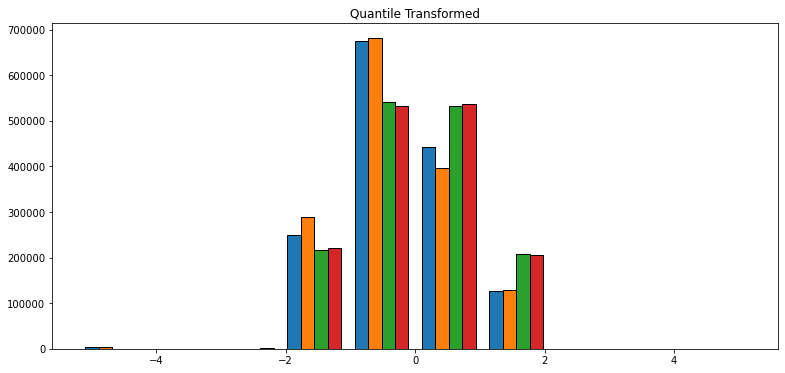

In [33]:
#Visualize this
plt.figure(figsize=(13, 6))
plt.hist(qt, ec='black')
plt.title('Quantile Transformed')

### 4. Use the QuantileTransformer, but omit the output_distribution argument. Visualize your results. What do you notice?

In [34]:
qt_no_output = QuantileTransformer(n_quantiles=10, random_state=0)

In [35]:
qt_no_output = qt_no_output.fit_transform(train[columns_to_scale])

Text(0.5, 1.0, 'Quantile Transformed no output distribution')

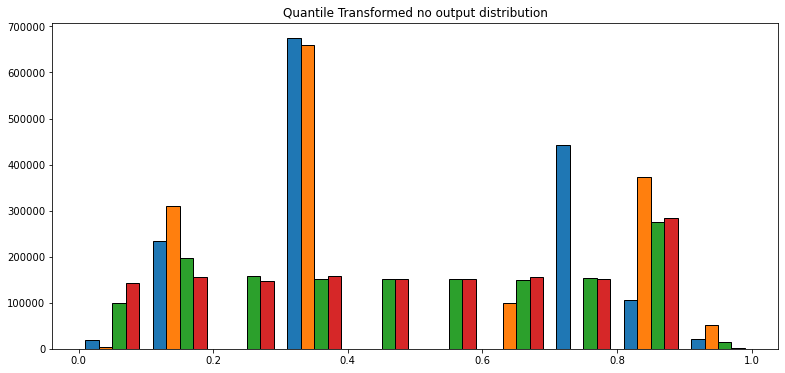

In [36]:
#Visualize this
plt.figure(figsize=(13, 6))
plt.hist(qt_no_output, ec='black')
plt.title('Quantile Transformed no output distribution')

### 5. Based on the work you've done, choose a scaling method for your dataset. Write a function within your prepare.py that accepts as input the train, validate, and test data splits, and returns the scaled versions of each. Be sure to only learn the parameters for scaling from your training data!

In [ ]:
train.head()

In [ ]:
#Prepare for modeling

#Drop columns not needed for modeling

def scale_data(train, 
               validate, 
               test, 
               columns_to_scale=['bedrooms', 'bathrooms', 'area','tax_value'],
               return_scaler=False):
    '''This function takes in train, validate, test, and outputs scaled data based on
    the chosen method (quantile scaling) using the columns selected as the only columns
    that will be scaled. This function also returns the scaler object as an array if set 
    to true'''
    # make copies of our original data
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
     # select a scaler
    scaler = QuantileTransformer(random_state=123, output_distribution='normal')
     # fit on train
    scaler.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [10]:
#Function to scale data using quantile transformer
scaler, train_scaled, validate_scaled, test_scaled = m.scale_data(train, validate, test, return_scaler=True)

In [ ]:
train_scaled.head(2)

In [ ]:
test_scaled.head(2)

In [ ]:
train.info()

In [37]:
print(f' Min value scaled Bedrooms is : {train_scaled.bedrooms.min()}')
print(f' Max value scaled Bedrooms is: {train_scaled.bedrooms.max()}')

 Min value scaled Bedrooms is : -5.199337582605575
 Max value scaled Bedrooms is: 5.19933758270342


In [38]:
## Use this function to visualize scalers

def visualize_scaler(scaler, df, columns_to_scale, bins=10):
    fig, axs = plt.subplots(len(columns_to_scale), 2, figsize=(16,9))
    df_scaled = df.copy()
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    for (ax1, ax2), col in zip(axs, columns_to_scale):
        ax1.hist(df[col], bins=bins)
        ax1.set(title=f'{col} before scaling', xlabel=col, ylabel='count')
        ax2.hist(df_scaled[col], bins=bins)
        ax2.set(title=f'{col} after scaling with {scaler.__class__.__name__}', xlabel=col, ylabel='count')
    plt.tight_layout()
#    return fig, axs

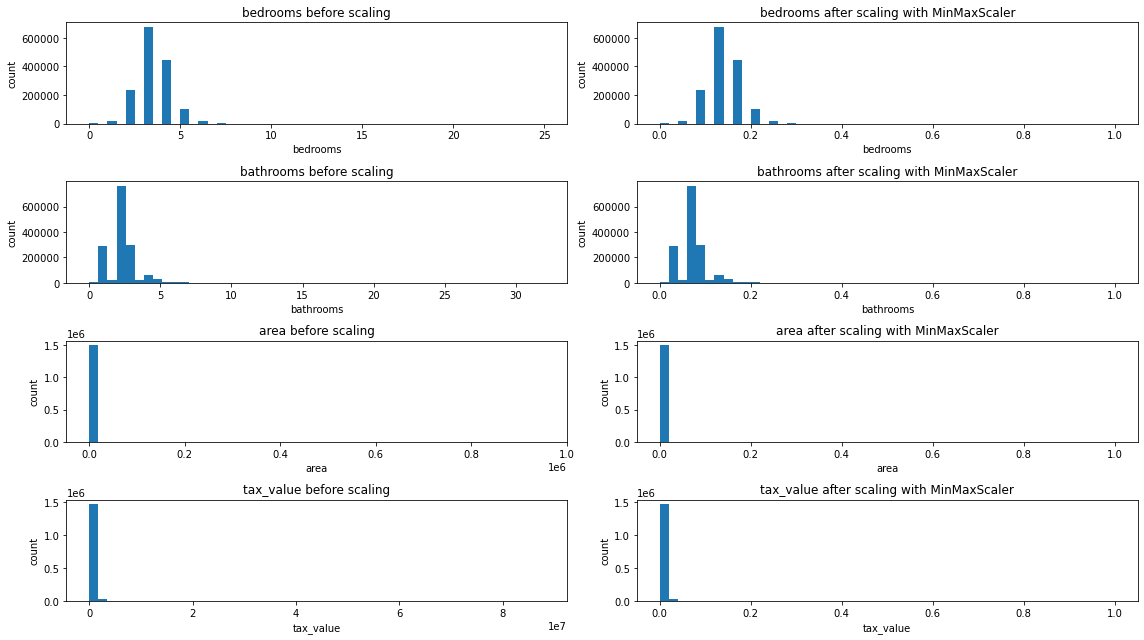

In [39]:
# MinMaxScaler Applied
visualize_scaler(scaler=MinMaxScaler(), 
                 df=train, 
                 columns_to_scale=columns_to_scale, 
                 bins=50)

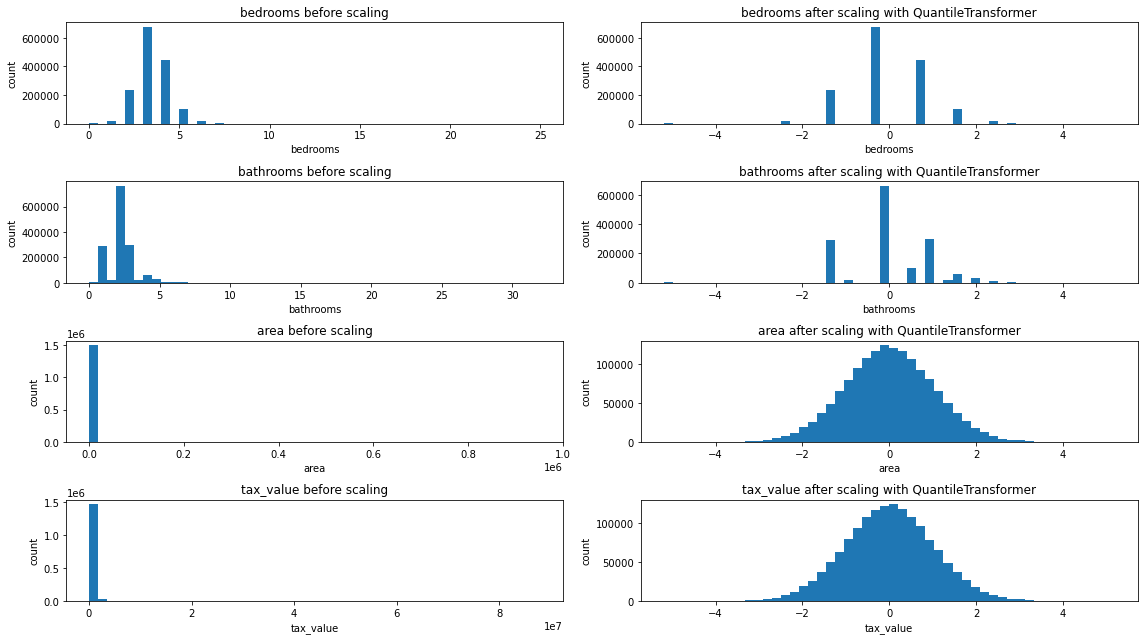

In [40]:
# QuantileTransformer Applied
visualize_scaler(scaler=QuantileTransformer(output_distribution='normal'), 
                 df=train,
                 columns_to_scale=columns_to_scale, 
                 bins=50)

In [ ]:
df.head()